# Experiment - Comparison of pattern development

- author: Marcelo de Gomensoro Malheiros
- revision: 2020-09
- license: MIT (attribution is not required but greatly appreciated)

In [1]:
import numpy as np
from scipy import ndimage

def turing_model(ma, mb, ka, kb, la, lb, da, db, dt, ia, ib, sa, sb, wrap):

    if wrap:
        ndimage.convolve(ma, ka, output=la, mode='wrap')
        ndimage.convolve(mb, kb, output=lb, mode='wrap')
    else:
        ndimage.convolve(ma, ka, output=la, mode='reflect')
        ndimage.convolve(mb, kb, output=lb, mode='reflect')
        
    na = ma + (16 - ma * mb      + da * la) * dt
    nb = mb + (ma * mb - mb - 12 + db * lb) * dt

    global a, b
    np.clip(na, ia, sa, out=a)
    np.clip(nb, ib, sb, out=b)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# turing: bounded non-linear Turing reaction-diffusion model - v6.3

kernel_a = kernel_b = np.array([[1, 4, 1], [4, -20, 4], [1, 4, 1]]) / 6

class Bunch(dict):
    def __init__(self, dictionary):
        dict.__init__(self, dictionary)
        self.__dict__.update(dictionary)

def turing(ratio=5, scale=1, speed=100, start=0, stop=1000, time=None, use_a=False, use_b=False, wrap=True,
           seed=1, ini_a=4, ini_b=4, var_a=0, var_b=1, shape=40, inf_a=0, inf_b=0, sup_a=1000, sup_b=1000,
           axis=False, cmap='inferno', first=False, info=False, limit=None, show='a', size=2, snap=4,
           detail=None, extent=(0, 10), func=None, out=None, dpi=100, interpolation='bilinear',
           detect=False, model=turing_model):

    # simulation init
    
    diff_a = ratio * scale
    diff_b = scale
    delta_t = 0.01 * speed / 100
    if time: stop = int(time * 100 / speed) + start

    global sim, a, b
    np.random.seed(seed)
    if type(shape) == int: shape = (shape, shape)
    if not use_a:
        a = np.full(shape, ini_a, dtype=float)
        if var_a != 0: a += np.random.random_sample(shape) * var_a
    if not use_b:
        b = np.full(shape, ini_b, dtype=float)
        if var_b != 0: b += np.random.random_sample(shape) * var_b
    lap_a = np.empty_like(a)
    lap_b = np.empty_like(b)
    is_nan = is_stable = is_uniform = last_a = False
    if info:
        high_a = high_b = - float('inf')
        low_a = low_b = float('inf')
        if info is True: info = 100
    if detect is True: detect = 100
    
    # plotting helper functions

    def draw(matrix, row):
        if axis: axes[row, col].axis('on')
        axes[row, col].imshow(matrix, cmap=cmap, interpolation=interpolation)
        axes[row, col].set_anchor('N')
        if limit:
            axes[row, col].set_xbound(0, limit[1] - 1)
            axes[row, col].set_ybound(0, limit[0] - 1)

    def plot():
        axes[0, col].set_title(iteration)
        row = 0
        if detail:
            if 'a' in show:
                t = a.copy()
                t[detail - 1,:] = t[detail + 1,:] = a.min()
                draw(t, row); row += 1
            if 'b' in show:
                t = b.copy()
                t[detail - 1,:] = t[detail + 1,:] = b.min()
                draw(t, row); row += 1
        else:
            if 'a' in show: draw(a, row); row += 1
            if 'b' in show: draw(b, row); row += 1

        if detail:
            axes[row, col].axis('on')
            axes[row, col].get_xaxis().set_visible(False)
            axes[row, col].grid()
            axes[row, col].plot((inf_a,) * shape[1], color='orange', linestyle='--')
            axes[row, col].plot((sup_a,) * shape[1], color='orange', linestyle='--')
            axes[row, col].plot(a[detail], color='orange')
            axes[row, col].plot((inf_b,) * shape[1], color='blue', linestyle='--')
            axes[row, col].plot((sup_b,) * shape[1], color='blue', linestyle='--')
            axes[row, col].plot(b[detail], color='blue')
            axes[row, col].set_anchor('N')
            axes[row, col].set_ybound(extent[0], extent[1])
    
    # plotting init
    
    axes = ax = ay = col = fig = rows = 0
    if 'a' in show: rows += 1
    if 'b' in show: rows += 1
    if detail: rows += 1
    if type(snap) == int:
        if snap > 100: print("too many captures, check 'snap' parameter"); return
        if first: snap = np.linspace(start, stop, snap, dtype=int)
        else: snap = np.linspace(start, stop, snap + 1, dtype=int)[1:]
    cols = len(snap)
    if show:
        fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=(cols * size, rows * size))
        for ay in axes:
            for ax in ay: ax.axis('off')
    if first and show:
        iteration = start
        plot()
        col += 1
    if type(limit) == int: limit = (limit, limit)

    # simulation loop

    for iteration in range(start + 1, stop + 1):
        if func: func(iteration, seed)
            
        if detect and iteration % detect == 0: last_a = a.copy()
        if a.shape != shape:
            shape = a.shape
            lap_a = np.empty_like(a)
            lap_b = np.empty_like(b)

        model(a, b, kernel_a, kernel_b, lap_a, lap_b, diff_a, diff_b, delta_t, inf_a, inf_b, sup_a, sup_b, wrap)

        if info and iteration % info == 0:
            high_a = max(a.max(), high_a)
            high_b = max(b.max(), high_b)
            low_a = min(a.min(), low_a)
            low_b = min(b.min(), low_b)       
        if detect and iteration % detect == 0:
            if a.ptp() < 0.001 or b.ptp() < 0.001: is_uniform = True
            elif np.isnan(np.sum(a)): is_nan = True
            elif type(last_a) != bool and np.allclose(a, last_a, atol=0.00001, rtol=0): is_stable = True
            last_a = a.copy()
                
        if is_stable or iteration in snap:
            if show: plot()
            col += 1
        if is_stable or is_uniform or is_nan: break
    
    # finalization
    
    if info:
        min_a, max_a, min_b, max_b = a.min(), a.max(), b.min(), b.max()
        print('A [{:.2f}, {:.2f}] <{:.2f}, {:.2f}> '.format(min_a, max_a, low_a, high_a),
              'B [{:.2f}, {:.2f}] <{:.2f}, {:.2f}> '.format(min_b, max_b, low_b, high_b), end='  ')
        if is_stable: print('stability of A at {}'.format(iteration))
        elif is_uniform: print('uniformity of A or B at {}'.format(iteration))
        elif is_nan: print('NaN found in A at {}'.format(iteration))
        else: print()

    if col == 0 or not show: plt.close()
    else:
        plt.show()
        if out: fig.savefig(out, bbox_inches='tight', dpi=dpi)

    del axes, ax, ay, col, cols, draw, fig, last_a, lap_a, lap_b, plot, rows
    sim = Bunch(locals())

In [3]:
# grow vertically: add new row to A and B
def grow_one_row_ab():
    global a, b
    rows, cols = a.shape
    new_a = np.zeros((rows + 1, cols))
    new_b = np.zeros((rows + 1, cols))
    new_a[:rows,:] = a[:,:]
    new_b[:rows,:] = b[:,:]
    for col in range(0, cols):
        row = np.random.randint(0, rows)
        new_a[(row+1):(rows+1), col] = a[row:rows, col]
        new_b[(row+1):(rows+1), col] = b[row:rows, col]
    a = new_a
    b = new_b

# grow horizontally: add new column to A and B
def grow_one_col_ab():
    global a, b
    rows, cols = a.shape
    new_a = np.zeros((rows, cols + 1))
    new_b = np.zeros((rows, cols + 1))
    new_a[:,:cols] = a[:,:]        
    new_b[:,:cols] = b[:,:]        
    for row in range(0, rows):
        col = np.random.randint(0, cols)
        new_a[row, (col+1):(cols+1)] = a[row, col:cols]
        new_b[row, (col+1):(cols+1)] = b[row, col:cols]
    a = new_a
    b = new_b

## Reference pattern

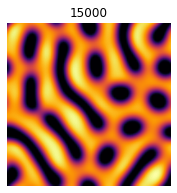

In [4]:
turing(wrap=True, stop=15000, shape=100, ratio=8, scale=10, speed=40, snap=[15000], size=3, show='b')
a0 = a.copy()
b0 = b.copy()

## No diffusion

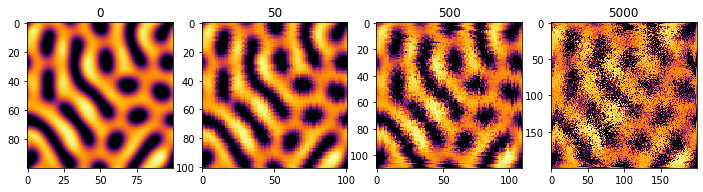

In [5]:
a = a0.copy()
b = b0.copy()
np.random.seed(1)
cols, size = 4, 3
fig, axes = plt.subplots(1, cols, squeeze=False, figsize=(cols * size, size))
col = 0
axes[0, col].axis('on')
axes[0, col].set_anchor('N')
axes[0, col].set_title(0)
axes[0, col].imshow(b, cmap='inferno')
for i in range(1, 5001):
    if i % 50 == 1:
        grow_one_col_ab()
        grow_one_row_ab()
    if i in [0, 1*50, 10*50, 100*50]:
        col += 1
        axes[0, col].axis('on')
        axes[0, col].set_anchor('N')
        axes[0, col].set_title(i)
        img = axes[0, col].imshow(b, cmap='inferno', interpolation='none')
plt.show()

## Reaction-diffusion

In [6]:
def g050_ab(i, s):
    if i % 50 == 1:
        grow_one_col_ab()
        grow_one_row_ab()

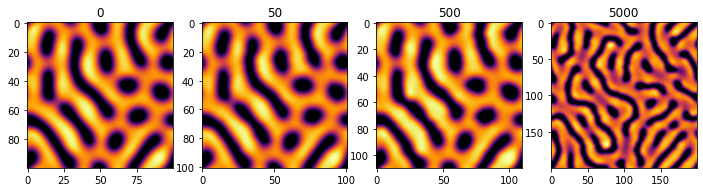

In [7]:
a = a0.copy()
b = b0.copy()
turing(wrap=True, stop=5000, ratio=8, scale=10, speed=40, use_a=True, use_b=True, axis=True, func=g050_ab,
       first=True, snap=[0, 1*50, 10*50, 100*50], show='b', size=3)

## Saturated reaction-diffusion

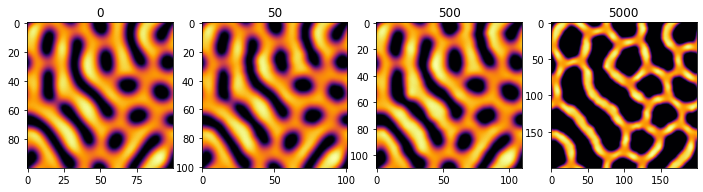

In [8]:
a = a0.copy()
b = b0.copy()
turing(wrap=True, stop=5000, ratio=8, scale=10, speed=40, use_a=True, use_b=True, axis=True, func=g050_ab,
       sup_a=5.7, first=True, snap=[0, 1*50, 10*50, 100*50], show='b', size=3)

## Reinforcement

In [9]:
from scipy import ndimage

def reinforcement_model(mc, kc, lc, dc, dt, t, w, g, wrap):

    if wrap: ndimage.convolve(mc, kc, output=lc, mode='wrap')
    else:    ndimage.convolve(mc, kc, output=lc, mode='reflect')

    global c
    c = mc + ((t - w - mc) * (t - mc) * (t + w - mc) * g + dc * lc) * dt

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# reinforcement: cubic autocatalytic reinforcement model - v6.3

kernel_c = np.array([[1, 4, 1], [4, -20, 4], [1, 4, 1]]) / 6

class Bunch(dict):
    def __init__(self, dictionary):
        dict.__init__(self, dictionary)
        self.__dict__.update(dictionary)

def reinforcement(threshold=1, width=1, scale=1, speed=100, start=0, stop=1000, time=None, use_c=False, wrap=True,
                  seed=1, ini_c=0, var_c=2, shape=40,
                  axis=False, cmap='inferno', first=False, info=False, limit=None, show='c', size=2, snap=4,
                  detail=None, extent=(-0.2, 2.2), func=None, out=None, dpi=100, interpolation='bilinear',
                  detect=False, model=reinforcement_model):

    # simulation init
    
    diff_c = scale
    delta_t = 0.01 * speed / 100
    if time: stop = int(time * 100 / speed) + start

    global sim, c
    np.random.seed(seed)
    if type(shape) == int: shape = (shape, shape)
    if not use_c:
        c = np.full(shape, ini_c, dtype=float)
        if var_c != 0: c += np.random.random_sample(shape) * var_c
    lap_c = np.empty_like(c)
    is_nan = is_stable = is_uniform = last_c = False
    if info:
        high_c = - float('inf')
        low_c = float('inf')
        if info is True: info = 100
    if detect is True: detect = 100
        
    # plotting helper functions

    def draw(matrix, row):
        if axis: axes[row, col].axis('on')
        axes[row, col].imshow(matrix, cmap=cmap, interpolation=interpolation)
        axes[row, col].set_anchor('N')
        if limit:
            axes[row, col].set_xbound(0, limit[1] - 1)
            axes[row, col].set_ybound(0, limit[0] - 1)

    def plot():
        axes[0, col].set_title(iteration)
        row = 0
        if detail:
            if 'c' in show:
                t = c.copy()
                t[detail - 1,:] = t[detail + 1,:] = c.min()
                draw(t, row); row += 1
        else:
            if 'c' in show: draw(c, row); row += 1

        if detail:
            axes[row, col].axis('on')
            axes[row, col].get_xaxis().set_visible(False)
            axes[row, col].grid()
            axes[row, col].plot((threshold - width,) * shape[1], color='orange', linestyle='--')
            axes[row, col].plot((threshold,        ) * shape[1], color='orange', linestyle='--')
            axes[row, col].plot((threshold + width,) * shape[1], color='orange', linestyle='--')
            axes[row, col].plot(c[detail], color='blue')
            axes[row, col].set_anchor('N')
            axes[row, col].set_ybound(extent[0], extent[1])

    # plotting init
    
    axes = ax = ay = col = fig = rows = 0
    if 'c' in show: rows += 1
    if detail: rows += 1
    if type(snap) == int:
        if snap > 100: print("too many captures, check 'snap' parameter"); return
        if first: snap = np.linspace(start, stop, snap, dtype=int)
        else: snap = np.linspace(start, stop, snap + 1, dtype=int)[1:]
    cols = len(snap)
    if show:
        fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=(cols * size, rows * size))
        for ay in axes:
            for ax in ay: ax.axis('off')
    if first and show:
        iteration = start
        plot()
        col += 1
    if type(limit) == int: limit = (limit, limit)

    # simulation loop

    gamma = 3 * np.sqrt(3) / (2 * width * width)
        
    for iteration in range(start + 1, stop + 1):
        if func: func(iteration, seed)

        if detect and iteration % detect == 0: last_c = c.copy()
        if c.shape != shape:
            shape = c.shape
            lap_c = np.empty_like(c)
        
        model(c, kernel_c, lap_c, diff_c, delta_t, threshold, width, gamma, wrap)
                
        if info and iteration % info == 0:
            high_c = max(c.max(), high_c)
            low_c = min(c.min(), low_c)
        if detect and iteration % detect == 0:
            if c.ptp() < 0.001: is_uniform = True
            elif np.isnan(np.sum(c)): is_nan = True
            elif type(last_c) != bool and np.allclose(c, last_c, atol=0.00001, rtol=0): is_stable = True
            last_c = c.copy()

        if is_stable or iteration in snap:
            if show: plot()
            col += 1
        if is_stable or is_uniform or is_nan: break
    
    # finalization
    
    if info:
        min_c, max_c = c.min(), c.max()
        print('C [{:.2f}, {:.2f}] <{:.2f}, {:.2f}>'.format(min_c, max_c, low_c, high_c), end='  ')
        if is_stable: print('stability of C at {}'.format(iteration))
        elif is_uniform: print('uniformity of C at {}'.format(iteration))
        elif is_nan: print('NaN found in C at {}'.format(iteration))
        else: print()

    if col == 0 or not show: plt.close()
    else:
        plt.show()
        if out: fig.savefig(out, bbox_inches='tight', dpi=dpi)

    del axes, ax, ay, col, cols, draw, fig, gamma, last_c, lap_c, plot, rows
    sim = Bunch(locals())

In [11]:
# grow vertically: add new row to C
def grow_one_row_c():
    global c
    rows, cols = c.shape
    new_c = np.zeros((rows + 1, cols))
    new_c[:rows,:] = c[:,:]
    for col in range(0, cols):
        row = np.random.randint(0, rows)
        # reduce division probability for middle rows
        if 0.45 * rows <= row <= 0.55 * rows:
            if np.random.random() < 0.5:
                row = np.random.randint(0, rows)
        new_c[(row+1):(rows+1), col] = c[row:rows, col]
    c = new_c

# grow horizontally: add new column to C
def grow_one_col_c():
    global c
    rows, cols = c.shape
    new_c = np.zeros((rows, cols + 1))
    new_c[:,:cols] = c[:,:]        
    for row in range(0, rows):
        col = np.random.randint(0, cols)
        new_c[row, (col+1):(cols+1)] = c[row, col:cols]
    c = new_c

In [12]:
def g050_c(i, s):
    if i % 50 == 1:
        grow_one_row_c()
        grow_one_col_c()

C [1.80, 9.80] <1.67, 9.80>  


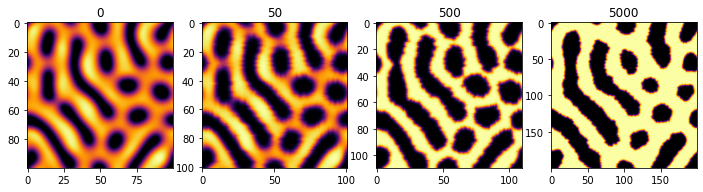

In [13]:
c = b0.copy()
reinforcement(stop=5000, use_c=True, axis=True, func=g050_c,
              scale=1.5, speed=40, threshold=5.8, width=4, info=True, first=True,
              snap=[0, 1*50, 10*50, 100*50], size=3)